In [37]:
import matplotlib.pyplot as plt
import os, math, numpy as np, pandas as pd
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline      import make_pipeline
from sklearn.metrics        import r2_score, mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [14]:
base_path = "/content/drive/MyDrive/blockhouse/"

In [3]:

# ---------- Configuration ----------
RAW_DIR = base_path + "Data"                      # base folder with 3 subfolders: FROG, CRWV, SOUN
OUT_DIR = base_path + "cleaned"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Process each ticker separately ----------
tickers = [d for d in os.listdir(RAW_DIR) if os.path.isdir(os.path.join(RAW_DIR, d))]

for symbol in tickers:
    sym_path = os.path.join(RAW_DIR, symbol)
    all_rows = []

    print(f"\n⏳ Processing {symbol}...")
    for fname in tqdm(os.listdir(sym_path)):
        if not fname.endswith(".csv"):
            continue

        full_path = os.path.join(sym_path, fname)
        df = pd.read_csv(full_path)

        # Extract trade_date from filename
        date_str = fname.replace(symbol + "_", "").replace(".csv", "").split()[0]
        trade_date = pd.to_datetime(date_str).date()

        # Convert px fields from nanodollars to dollars
        for col in df.columns:
            if "_px_" in col:
                df[col] *= 1e-9

        # Convert timestamp to datetime
        df['ts_event_dt'] = pd.to_datetime(df['ts_event'], unit='ns')
        df['ts_minute'] = df['ts_event_dt'].dt.floor('min')

        # Add symbol/date and keep last row per minute
        df['symbol'] = symbol
        df['trade_date'] = trade_date
        df_min = df.groupby('ts_minute', as_index=False).tail(1)
        all_rows.append(df_min)

    # Combine and save per symbol
    result = pd.concat(all_rows, ignore_index=True)
    out_path = os.path.join(OUT_DIR, f"{symbol}_book_cleaned.parquet")
    result.to_parquet(out_path, index=False)
    print(f"✔ Saved {symbol} data to {out_path}")



⏳ Processing SOUN...


100%|██████████| 21/21 [01:03<00:00,  3.02s/it]


✔ Saved SOUN data to /content/drive/MyDrive/blockhouse/cleaned/SOUN_book_cleaned.parquet

⏳ Processing FROG...


100%|██████████| 21/21 [00:17<00:00,  1.19it/s]


✔ Saved FROG data to /content/drive/MyDrive/blockhouse/cleaned/FROG_book_cleaned.parquet

⏳ Processing CRWV...


100%|██████████| 21/21 [00:32<00:00,  1.53s/it]

✔ Saved CRWV data to /content/drive/MyDrive/blockhouse/cleaned/CRWV_book_cleaned.parquet



📈 Plotting FROG...


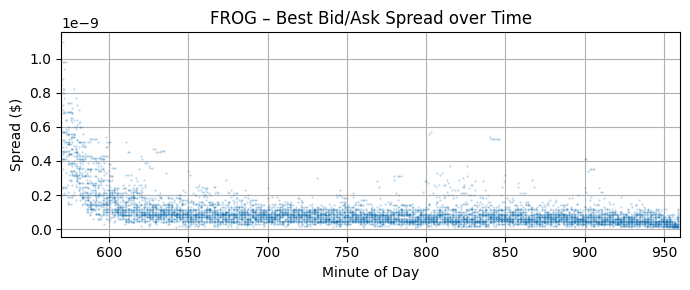


📈 Plotting CRWV...


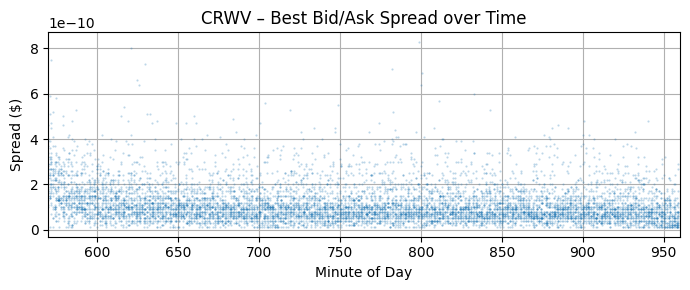


📈 Plotting SOUN...


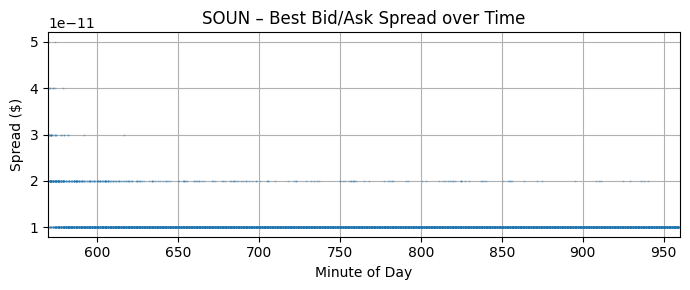

In [6]:

CLEANED_DIR = base_path + "cleaned"
symbols = ["FROG", "CRWV", "SOUN"]

for symbol in symbols:
    print(f"\n📈 Plotting {symbol}...")
    files = sorted([f for f in os.listdir(CLEANED_DIR) if f.startswith(symbol) and f.endswith(".parquet")])

    dfs = []
    for f in files:
        path = os.path.join(CLEANED_DIR, f)
        df = pd.read_parquet(path)
        dfs.append(df)

    full_df = pd.concat(dfs, ignore_index=True)

    # Convert to US/Eastern timezone if not already
    if full_df['ts_event_dt'].dt.tz is None:
        full_df['ts_event_dt'] = full_df['ts_event_dt'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
    else:
        full_df['ts_event_dt'] = full_df['ts_event_dt'].dt.tz_convert('US/Eastern')

    # Calculate spread and minute of day
    full_df['spread'] = full_df['ask_px_00'] - full_df['bid_px_00']
    full_df['minute_of_day'] = full_df['ts_event_dt'].dt.hour * 60 + full_df['ts_event_dt'].dt.minute

    # Filter to market open-close range (570–960)
    full_df = full_df[full_df['minute_of_day'].between(570, 960)]

    # Plot
    plt.figure(figsize=(7, 3))
    plt.plot(full_df['minute_of_day'], full_df['spread'], '.', markersize=1, alpha=0.3)
    plt.xlabel("Minute of Day")
    plt.ylabel("Spread ($)")
    plt.title(f"{symbol} – Best Bid/Ask Spread over Time")
    plt.xlim(570, 960)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [16]:

CLEAN_DIR    = os.path.join(base_path, "cleaned")
OUT_DIR      = os.path.join(base_path, "slippage")
os.makedirs(OUT_DIR, exist_ok=True)

ORDER_SIZES  = [50, 100, 150, 200, 250, 300]   # sizes to simulate

def vwap_buy(row, size):
    """VWAP for a hypothetical buy of <size> shares via ask ladder."""
    remain, cost = size, 0.0
    for lvl in range(10):
        px  = row[f"ask_px_{lvl:02d}"]
        qty = row[f"ask_sz_{lvl:02d}"]
        take = min(qty, remain)
        cost += take * px
        remain -= take
        if remain == 0:
            return cost / size
    return math.nan   # not enough depth

for file in sorted(os.listdir(CLEAN_DIR)):
    if not file.endswith("_book_cleaned.parquet"):
        continue
    if file.startswith("all_"):          # skip the pooled file
        continue

    print(f"⏳ Building slippage rows for {file} …")
    df = pd.read_parquet(os.path.join(CLEAN_DIR, file))

    rows = []
    for _, snap in tqdm(df.iterrows(), total=len(df)):
        mid  = (snap["ask_px_00"] + snap["bid_px_00"]) / 2
        spread = snap["ask_px_00"] - snap["bid_px_00"]
        meta = {
            "symbol"     : snap["symbol"],
            "trade_date" : snap["trade_date"],
            "ts_minute"  : snap["ts_minute"],
            "spread"     : spread
        }
        for sz in ORDER_SIZES:
            vwap = vwap_buy(snap, sz)
            if math.isnan(vwap):
                continue
            rows.append({**meta,
                         "order_size": sz,
                         "vwap"      : vwap,
                         "mid_price" : mid,
                         "slippage"  : vwap - mid})

    out_df = pd.DataFrame(rows)
    out_df.to_parquet(outfile, index=False)
    print(f"✔ Saved → {outfile}")


⏳ Building slippage rows for CRWV_book_cleaned.parquet …


100%|██████████| 8189/8189 [00:01<00:00, 7153.37it/s]


✔ Saved → /content/drive/MyDrive/blockhouse/slippage/all_slippage.parquet
⏳ Building slippage rows for FROG_book_cleaned.parquet …


100%|██████████| 8162/8162 [00:00<00:00, 10083.19it/s]


✔ Saved → /content/drive/MyDrive/blockhouse/slippage/all_slippage.parquet
⏳ Building slippage rows for SOUN_book_cleaned.parquet …


100%|██████████| 8190/8190 [00:01<00:00, 5630.65it/s]


✔ Saved → /content/drive/MyDrive/blockhouse/slippage/all_slippage.parquet


In [17]:
SLIP_DIR = base_path + "slippage"
pool = {}
for f in os.listdir(SLIP_DIR):
    if not f.endswith("_slippage.parquet"): continue
    sym = f.split("_")[0]
    pool.setdefault(sym, []).append(pd.read_parquet(os.path.join(SLIP_DIR, f)))

for sym in pool:
    pool[sym] = pd.concat(pool[sym], ignore_index=True)
    print(sym, "rows →", len(pool[sym]))


CRWV rows → 49093
FROG rows → 48960
SOUN rows → 49140
all rows → 49140


In [18]:
for sym, df in pool.items():
    df['minute_of_day'] = df['ts_minute'].dt.hour*60 + df['ts_minute'].dt.minute
    df['abs_slip']      = df['slippage'].abs()


In [22]:
models = {}
for sym, df in pool.items():
    if sym in ["FROG", "CRWV", "SOUN"]:
      X = df[['order_size', 'spread', 'minute_of_day']]
      y = df['abs_slip']
      mdl = make_pipeline(StandardScaler(with_mean=False), LinearRegression()).fit(X, y)
      models[sym] = mdl
      print(sym, "R² =", mdl.score(X, y))
      print(df.columns)


CRWV R² = 0.6466489457064566
Index(['symbol', 'trade_date', 'ts_minute', 'spread', 'order_size', 'vwap',
       'mid_price', 'slippage', 'minute_of_day', 'abs_slip'],
      dtype='object')
FROG R² = 0.7620324316815463
Index(['symbol', 'trade_date', 'ts_minute', 'spread', 'order_size', 'vwap',
       'mid_price', 'slippage', 'minute_of_day', 'abs_slip'],
      dtype='object')
SOUN R² = 0.5964643997640997
Index(['symbol', 'trade_date', 'ts_minute', 'spread', 'order_size', 'vwap',
       'mid_price', 'slippage', 'minute_of_day', 'abs_slip'],
      dtype='object')


CRWV: best Poly degree 4   R²=0.6572   RMSE=3.23e-11
FROG: best Poly degree 4   R²=0.7787   RMSE=2.81e-11
SOUN: best Poly degree 4   R²=0.6096   RMSE=1.12e-12


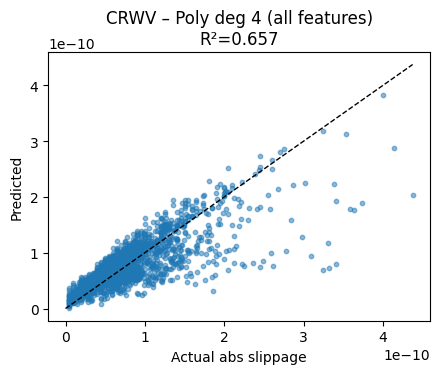

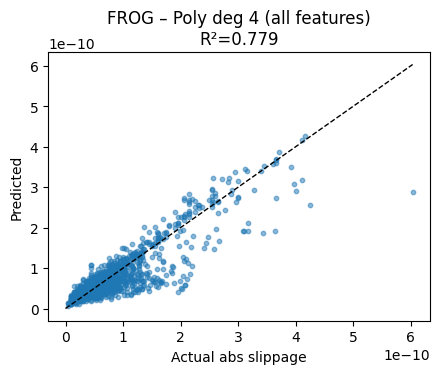

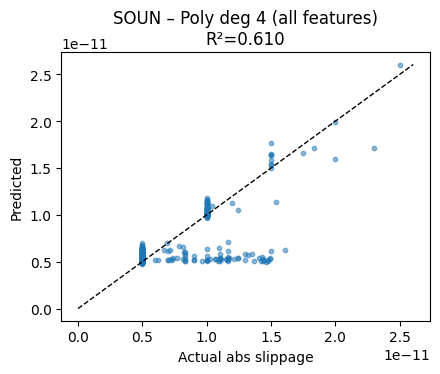

In [27]:

all_numeric = ['order_size', 'spread', 'mid_price', 'minute_of_day']
deg_range   = range(1, 5)   # polynomial degrees 1-4

best_per_sym = {}

for sym, df in pool.items():
    y = df['abs_slip'].values

    X_base = df[all_numeric].values   # full set of numeric predictors

    for deg in deg_range:
        pipe = make_pipeline(
            PolynomialFeatures(degree=deg, include_bias=False),
            StandardScaler(with_mean=False),
            LinearRegression()
        )
        pipe.fit(X_base, y)
        y_pred = pipe.predict(X_base)
        r2   = r2_score(y, y_pred)
        rmse = mean_squared_error(y, y_pred) ** 0.5
        if (sym not in best_per_sym) or (r2 > best_per_sym[sym]['r2']):
            best_per_sym[sym] = {
                'deg'  : deg,
                'r2'   : r2,
                'rmse' : rmse,
                'model': pipe
            }

for sym, info in best_per_sym.items():
    if sym != "all":
      print(f"{sym}: best Poly degree {info['deg']}   R²={info['r2']:.4f}   RMSE={info['rmse']:.2e}")

for sym, info in best_per_sym.items():
    if sym == "all":
      continue
    else:
      df   = pool[sym]
      y    = df['abs_slip'].values
      X    = df[all_numeric].values
      yhat = info['model'].predict(X)

      samp = np.random.choice(len(y), size=2000, replace=False)
      plt.figure(figsize=(4.5,4))
      plt.scatter(y[samp], yhat[samp], s=10, alpha=0.5)
      lim = max(y[samp].max(), yhat[samp].max())
      plt.plot([0, lim],[0, lim],'k--',lw=1)
      plt.xlabel("Actual abs slippage")
      plt.ylabel("Predicted")
      plt.title(f"{sym} – Poly deg {info['deg']} (all features)\nR²={info['r2']:.3f}")
      plt.tight_layout(); plt.show()


,symbol,degree,R2,RMSE,equation
0,CRWV,1,0.649718,3.264131e-11,-1.90e-12 + 1.03e-13·order_size + 5.19e-01·spr...
1,CRWV,2,0.653009,3.248761e-11,7.10e-11 + 1.24e-13·order_size + 6.17e-01·spre...
2,CRWV,3,0.655844,3.235463e-11,2.19e-09 + 2.32e-13·order_size + 3.91e-01·spre...
3,CRWV,4,0.657250,3.228848e-11,-5.79e-09 + 8.36e-12·order_size + 5.58e+00·spr...
4,FROG,1,0.762115,2.911957e-11,2.80e-11 + 7.83e-14·order_size + 5.08e-01·spre...
5,FROG,2,0.767932,2.876132e-11,-6.53e-10 + 1.83e-13·order_size + 8.89e-01·spr...
6,FROG,3,0.775545,2.828561e-11,1.46e-09 + -1.65e-12·order_size + 6.73e-01·spr...
7,FROG,4,0.778664,2.808844e-11,-1.92e-08 + 8.32e-12·order_size + -3.60e+01·sp...
8,SOUN,1,0.597044,1.136360e-12,1.59e-12 + 1.25e-15·order_size + 5.10e-01·spre...
9,SOUN,2,0.603003,1.127925e-12,6.45e-12 + 1.00e-14·order_size + 5.80e-01·spre...


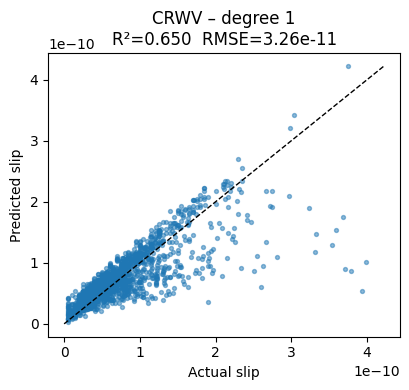

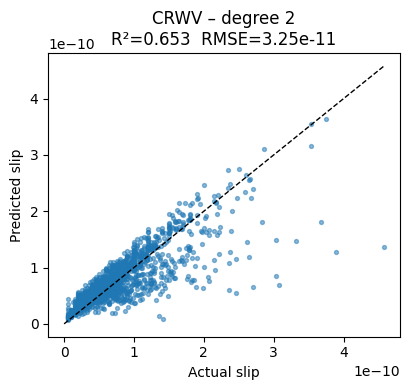

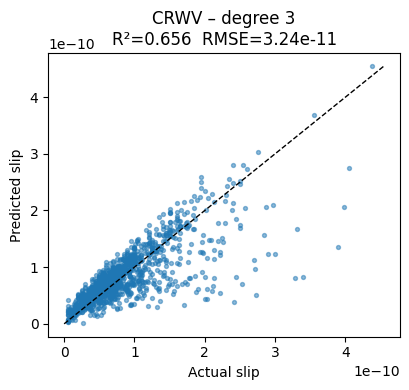

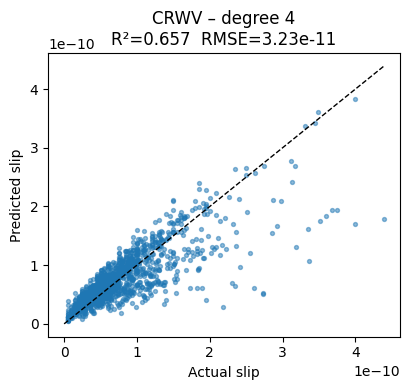

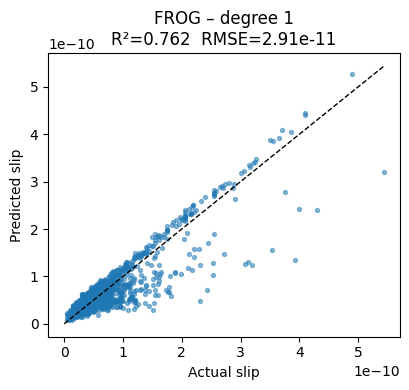

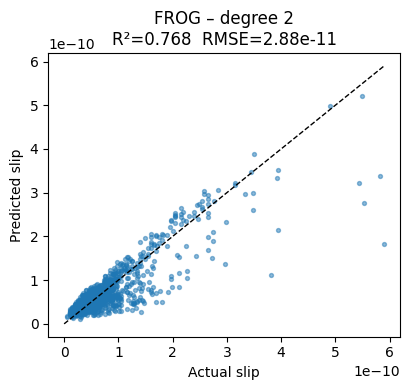

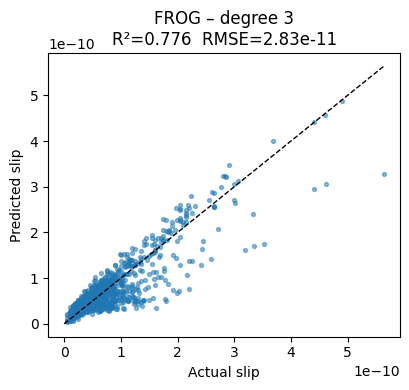

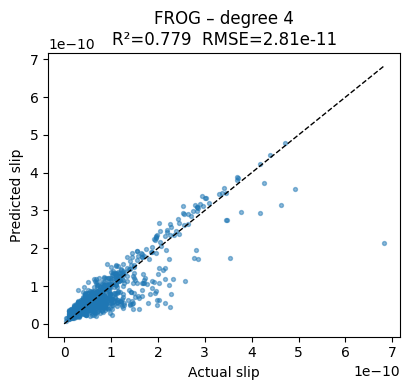

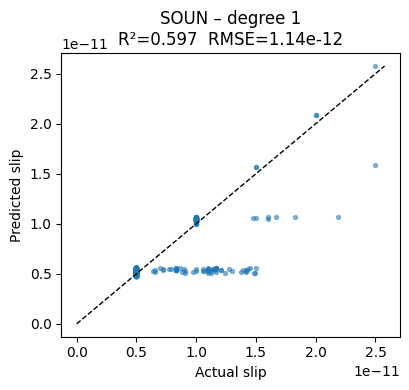

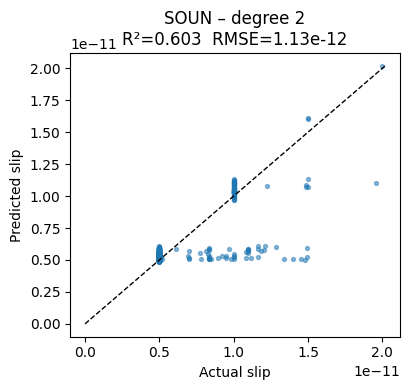

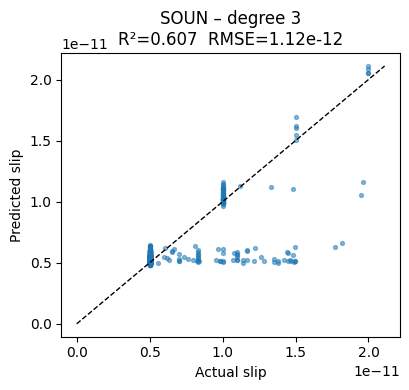

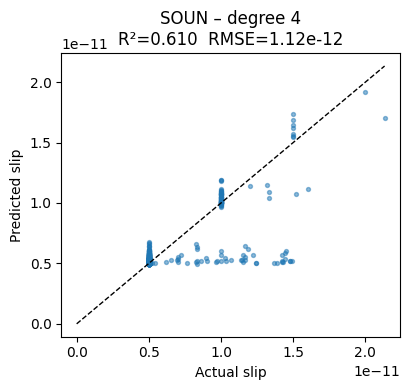

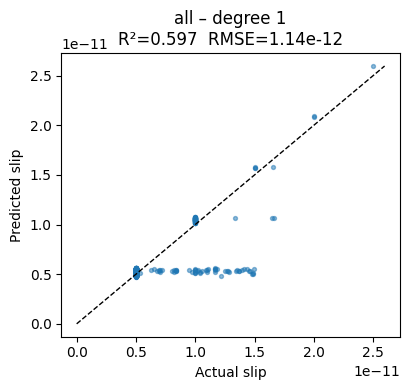

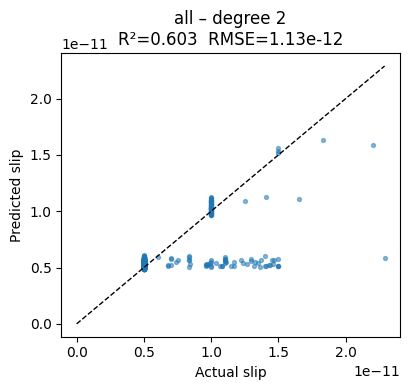

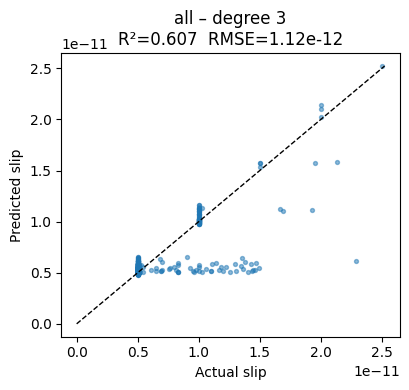

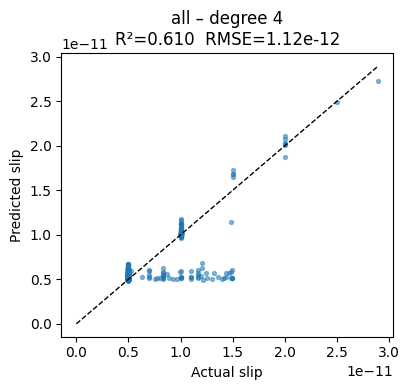

In [34]:

# ------------------------------------------------------------
all_numeric = ['order_size', 'spread', 'mid_price', 'minute_of_day']
deg_range   = range(1, 5)                      # degrees 1-4
rows        = []                               # collect results

for sym, df in pool.items():
    y = df['abs_slip'].values
    X_base = df[all_numeric].values

    for deg in deg_range:
        pipe = make_pipeline(
            PolynomialFeatures(degree=deg, include_bias=False),
            StandardScaler(with_mean=False),
            LinearRegression()
        )
        pipe.fit(X_base, y)
        y_pred = pipe.predict(X_base)
        r2   = r2_score(y, y_pred)
        rmse = mean_squared_error(y, y_pred) ** 0.5

        # build readable equation
        poly   = pipe.named_steps['polynomialfeatures']
        scaler = pipe.named_steps['standardscaler']
        lr     = pipe.named_steps['linearregression']
        coef   = lr.coef_ / scaler.scale_
        names  = poly.get_feature_names_out(all_numeric)
        eq_str = " + ".join([f"{c:.2e}·{n.replace(' ','·')}"
                             for c, n in zip(coef, names) if abs(c) > 1e-16])
        equation = f"{lr.intercept_:.2e} + {eq_str}"

        rows.append({
            "symbol"   : sym,
            "degree"   : deg,
            "R2"       : r2,
            "RMSE"     : rmse,
            "equation" : equation,
            "model"    : pipe         # keep ref for plotting
        })

# -----------------------------------------------
results_df = pd.DataFrame(rows).sort_values(["symbol","degree"])
display(results_df[["symbol","degree","R2","RMSE","equation"]])

# -----------------------------------------------
# Plot Actual vs Predicted for every degree
for sym in results_df["symbol"].unique():
    df_sym  = pool[sym]
    y_true  = df_sym['abs_slip'].values
    X_sym   = df_sym[all_numeric].values

    for deg in deg_range:
        mdl_row = results_df[(results_df.symbol==sym)&(results_df.degree==deg)].iloc[0]
        y_hat   = mdl_row["model"].predict(X_sym)
        samp    = np.random.choice(len(y_true), size=1500, replace=False)

        plt.figure(figsize=(4.2,4))
        plt.scatter(y_true[samp], y_hat[samp], s=8, alpha=0.5)
        lim = max(y_true[samp].max(), y_hat[samp].max())
        plt.plot([0,lim],[0,lim],'k--',lw=1)
        plt.title(f"{sym} – degree {deg}\nR²={mdl_row.R2:.3f}  RMSE={mdl_row.RMSE:.2e}")
        plt.xlabel("Actual slip"); plt.ylabel("Predicted slip")
        plt.tight_layout(); plt.show()


In [38]:
results_df.to_csv("results.csv",index = False)